# **PicoScope**: efficiencies and source isotropy

## Preliminary operations

### Paths

In [1]:
USER_PATH = "/home/rocco/University/APL/Lab/"
DATA_PATH = USER_PATH + "data/pico_eff_201120/"
SAVE_PATH = "../../plots/data/picoscope/"

### Flags

In [2]:
UNZIP_DATA    = False
WAVE2NUMPY    = False
PLOT_WAVE     = False
PLOT_MAV_WAVE = False
REJECT_3SIGMA = False
SAVE_DATA     = True

### Load packages

In [3]:
import os
import ROOT
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette

Welcome to JupyROOT 6.22/06


In [4]:
from ROOT import TF1
from ROOT import TCanvas, TGraph, TGraphErrors

### Settings

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

## Convert waveform files to numpy array and store

### Unzip all data archives and get number of events

In [6]:
if UNZIP_DATA:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)

        if not os.path.exists("data"):
            os.system("unzip data.zip -d data")
        os.chdir("../")

### Convert to numpy array

In [7]:
if WAVE2NUMPY:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)

        if not os.path.exists(d+".npy"):
            N = len(os.listdir("./data"))
            M = 5000

            data = np.zeros((N,M),dtype=np.int16)
            for f,i in zip(os.listdir("./data"), range(N)):
                data[i,:] = np.loadtxt("./data/run_"+str(i)+"_segment_0.rpsd")
            np.save(d+".npy", data)

        os.chdir("../")

## Analysis

In [8]:
M   = 20     # moving average (MAV) filter M
TRG = 500    # trigger threshold in mV
# SC = 33    # picoscoper center in steps

### Collect data angle

In [12]:
angles = []
events = []
err_angles = []
err_events = []

pico_step = []
pico_rad  = []
pico_deg  = []
pico_seg  = []
pico_ev   = []
pico_t    = []
pico_r    = []

pico_step_err = []
pico_rad_err  = []
pico_deg_err  = []
pico_ev_err   = []
pico_r_err    = []



os.chdir(DATA_PATH)
for d in os.listdir("."):
    # print(d)
    os.chdir(d)
    run = d.split("_")[0]
    
    #######################################################################
    # CHECK TRIGGER
    #######################################################################
    if (str(TRG)+"mV") not in d:
        os.chdir(DATA_PATH)
        continue
    #######################################################################
    
    #######################################################################
    # TAKE DIRECTION FROM DIR NAME
    #######################################################################
    if "DX" in d:
        sign = -1
    elif "SX" in d:
        sign = +1
    else:
        sign = 0
    #######################################################################

    #######################################################################
    # TAKE DATA FROM run FILE
    #######################################################################
    file = open("run")
    line = file.readlines()
    for l in line:
        if (l.startswith("n_segments")):
            n_seg = int(l.split('=')[1].strip())
            pico_seg.append(n_seg)
        if (l.startswith("run_time")):
            run_time = int(l.split('=')[1].strip())
    file.close()
    
    steps = sign * int(''.join(filter(lambda i: i.isdigit(), run))) # - SC
    #######################################################################
    
    #######################################################################
    # TAKE DATA FROM run_BlockTimes.txt
    #######################################################################
    times  = np.loadtxt("run_BlockTimes.txt")
    blocks = times.shape[0]
    events = blocks * n_seg
    # print(times.shape)
    if times.shape != (2,):
        t  = times[-1,1] - times[0,0] - np.sum(times[1:,0]-times[:-1,1])
    else:
        t  = run_time

    pico_step.append(steps)
    pico_rad.append(steps * 0.9 * np.pi / 180.0)
    pico_deg.append(steps * 0.9)
    pico_t.append(t)
    pico_ev.append(events)
    pico_r.append(events / t * 3600)
    #######################################################################
    
    #######################################################################
    # COMPUTE ERRORS
    #######################################################################
    pico_step_err.append(0.05) # 1.0 / np.sqrt(12.0)
    pico_rad_err .append(0.05 * 0.9 * np.pi / 180.0)
    pico_deg_err .append(0.05 * 0.9)
    pico_ev_err  .append(np.sqrt(events))
    pico_r_err   .append(np.sqrt(events) / t * 3600)
    #######################################################################

    
    #######################################################################
    # TAKE DATA FROM ALL WAVEFORMS
    #######################################################################
    if WAVE2NUMPY:
        data     = np.load(d+".npy")
        data_mav = np.apply_along_axis(moving_average, 1, data, M)

        baseline_mask = np.arange(data_mav.shape[1])
        baseline_mask = ((baseline_mask<1000) | (baseline_mask>3000))

        baseline = np.sum(data_mav[:,baseline_mask], axis=1) / data_mav[:,baseline_mask].shape[1]

        data_mav_int = np.sum(data_mav, axis=1) - baseline*data_mav.shape[1]

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        if REJECT_3SIGMA:
            mask_t = np.logical_and(data_mav_int<data_mav_int_mean+data_mav_int_var*3, data_mav_int>data_mav_int_mean-data_mav_int_var*3)
            mask_f = np.logical_not(mask_t)
        else:
            mask_t = np.ones(data_mav_int.shape, dtype=bool)
            mask_f = np.logical_not(mask_t)

        if PLOT_WAVE:
            fig=plt.figure(figsize=(12, 4))
            plt.subplot(1,2,1)
            if mask_f.shape[0] != 0:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
                plt.plot(np.where(mask_f)[0], data_mav_int[mask_f], "o", markersize=1.5)
            else:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
            plt.title(d)

            plt.subplot(1,2,2)
            if mask_f.shape[0] != 0:
                plt.hist([data_mav_int[mask_t], data_mav_int[mask_f]], bins=50, stacked=True)
            else:
                plt.hist(data_mav_int[mask_t], bins=50, stacked=True)
            plt.yscale("log")
            plt.title(d)
            plt.show()
    #######################################################################

    os.chdir(DATA_PATH)

### Events distribution

In [14]:
col = palette.brewer['RdYlGn'][10]

In [15]:
d = {
    "pico_step"     : pico_step,
    "pico_rad"      : pico_rad,
    "pico_deg"      : pico_deg,
    "pico_seg"      : pico_seg,
    "pico_ev"       : pico_ev,
    "pico_t"        : pico_t,
    "pico_r"        : pico_r,
    "pico_step_err" : pico_step_err,
    "pico_rad_err"  : pico_rad_err,
    "pico_deg_err"  : pico_deg_err,
    "pico_ev_err"   : pico_ev_err,
    "pico_r_err"    : pico_r_err
}

df = pd.DataFrame(data=d)
df = df.sort_values(by=['pico_step'])

In [22]:
mean = np.average(df["pico_r"], weights=(1/np.square(df["pico_r_err"])))

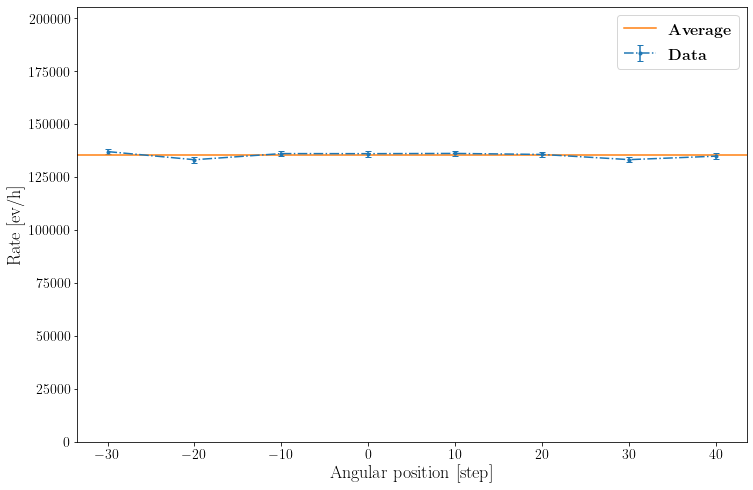

In [37]:
plt.figure(figsize=(12,8))

plt.errorbar(
    x               = df["pico_step"],
    y               = df["pico_r"],
    # xerr            = df_exp["pico_step_err"],
    yerr            = df["pico_r_err"],
    fmt             ='-.o',
    markersize      = 3,
    capsize         = 3,
    # markerfacecolor = col[0],
    # color           = col[1],
    # ecolor          = col[0],
    label           = r"\bf{Data}",
    alpha           = 1
)

plt.axhline(
    y    =mean,
    color="C1",
    linewidth=1.5,
    label=r"\bf{Average}"
)

plt.ylim(np.max(df["pico_r"])*0.0, np.max(df["pico_r"])*1.5)
plt.xlabel("Angular position [step]")
plt.ylabel("Rate [ev/h]")
plt.legend()
plt.show()

## Save data

In [38]:
if SAVE_DATA:
    df.to_csv(SAVE_PATH + "pico_data_isotropy.csv", index=False)